# Model Testing

Here we will test different models to see which one performs best on our data. We will test different models:


We will work on already prepared dataset.

## Linear Regression

In [40]:
import pandas as pd
import numpy as np
import data_preprocessing as dp

jobs_df = pd.read_csv('data/cleared/linkedin_data.csv')

# Dropping unnecessary columns
jobs_df = jobs_df.drop(['Job_Desc', 'Job_Ttl', 'max_sal', 'min_sal', 'Co_Nm', 'py_prd', 'loc'], axis=1)

jobs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12491 entries, 0 to 12490
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Flw_Cnt        12491 non-null  int64  
 1   Is_Supvsr      12491 non-null  bool   
 2   med_sal        12491 non-null  float64
 3   st_code        12491 non-null  object 
 4   is_remote      12491 non-null  int64  
 5   views          12491 non-null  int64  
 6   xp_lvl         12491 non-null  object 
 7   mean_year_sal  12491 non-null  float64
dtypes: bool(1), float64(2), int64(3), object(2)
memory usage: 695.4+ KB


### Data Preparation


In [41]:
mean_sal_by_xp_lvl = jobs_df.groupby('xp_lvl')['med_sal'].mean()

mean_sal_by_st_code = jobs_df.groupby('st_code')['med_sal'].mean()

mean_sal_by_wrk_type = jobs_df.groupby('wrk_typ')['med_sal'].mean() 

jobs_df['mean_sal_by_st_code'] = jobs_df['st_code'].map(mean_sal_by_st_code)

jobs_df['mean_sal_by_xp_lvl'] = jobs_df['xp_lvl'].map(mean_sal_by_xp_lvl)

jobs_df['mean_sal_by_wrk_type'] = jobs_df['wrk_typ'].map(mean_sal_by_wrk_type)

jobs_df_copy = jobs_df.copy()
jobs_df_copy = jobs_df_copy.drop(['st_code'], axis=1)

y = jobs_df['med_sal'].values
X = jobs_df[['Flw_Cnt', 'Is_Supvsr', 'is_remote', 'views', 'mean_sal_by_xp_lvl', 'mean_sal_by_xp_lvl']].values

In [42]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
y_train_scaled = scaler.fit_transform(y_train.reshape(-1, 1))

regressor = KNeighborsRegressor(n_neighbors=5, metric='minkowski', p=2)
regressor.fit(X_train_scaled, y_train_scaled)

y_pred = regressor.predict(X_test_scaled)
y_pred = scaler.inverse_transform(y_pred)
y_pred = y_pred.flatten()
print('Mean squared error: ', mean_squared_error(y_test, y_pred))

scores = cross_val_score(regressor, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')

rmse_scores = np.sqrt(-scores)

print('RMSE scores: ', rmse_scores)
print('Mean RMSE: ', rmse_scores.mean())



Mean squared error:  1332364488.9019165
RMSE scores:  [37128.48804292 36588.03928559 36217.60848188 36713.72599455
 36241.31766995]
Mean RMSE:  36577.8358949774


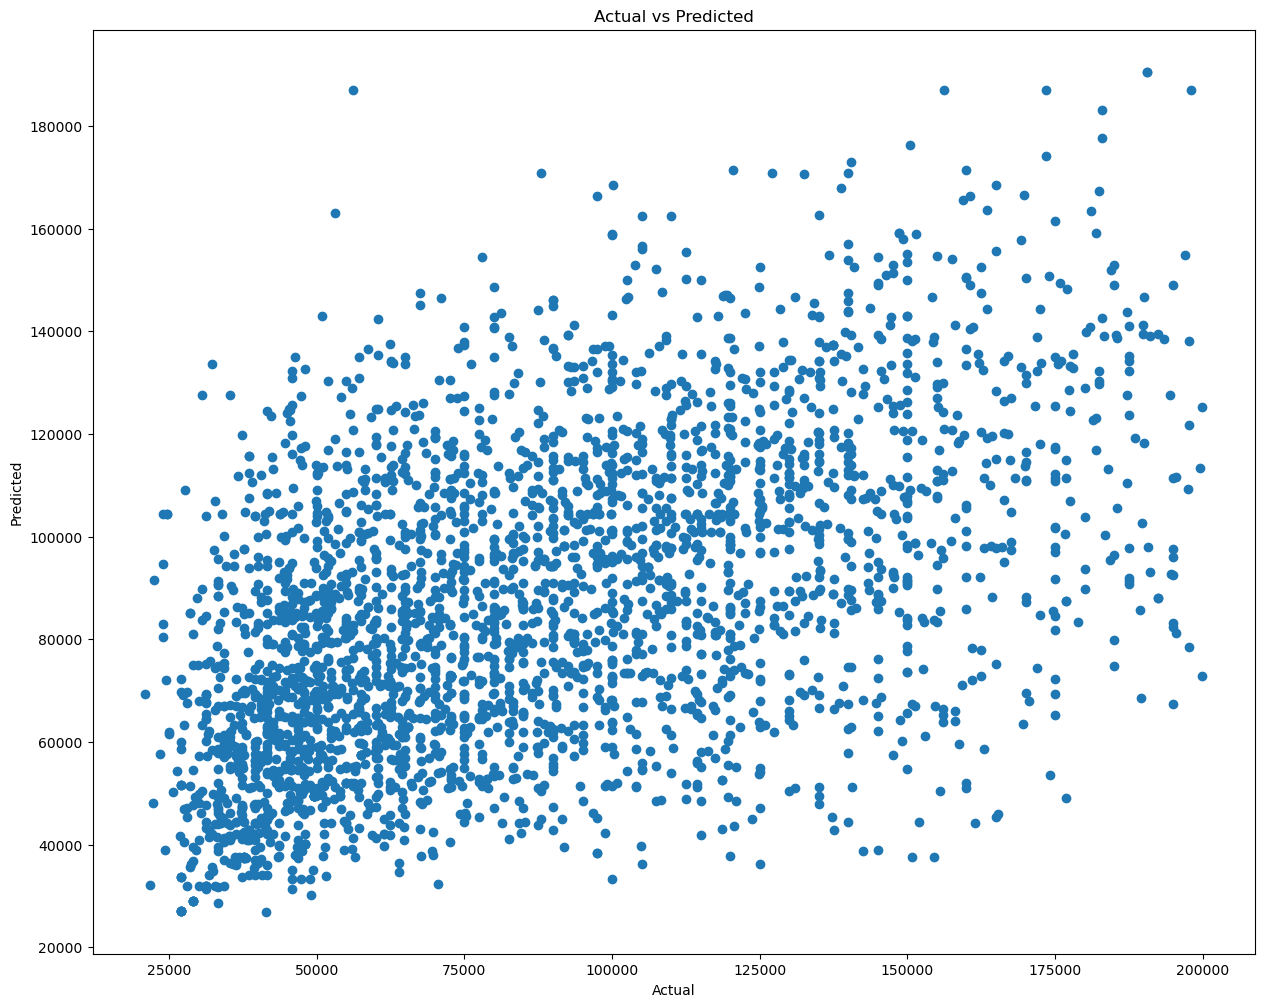

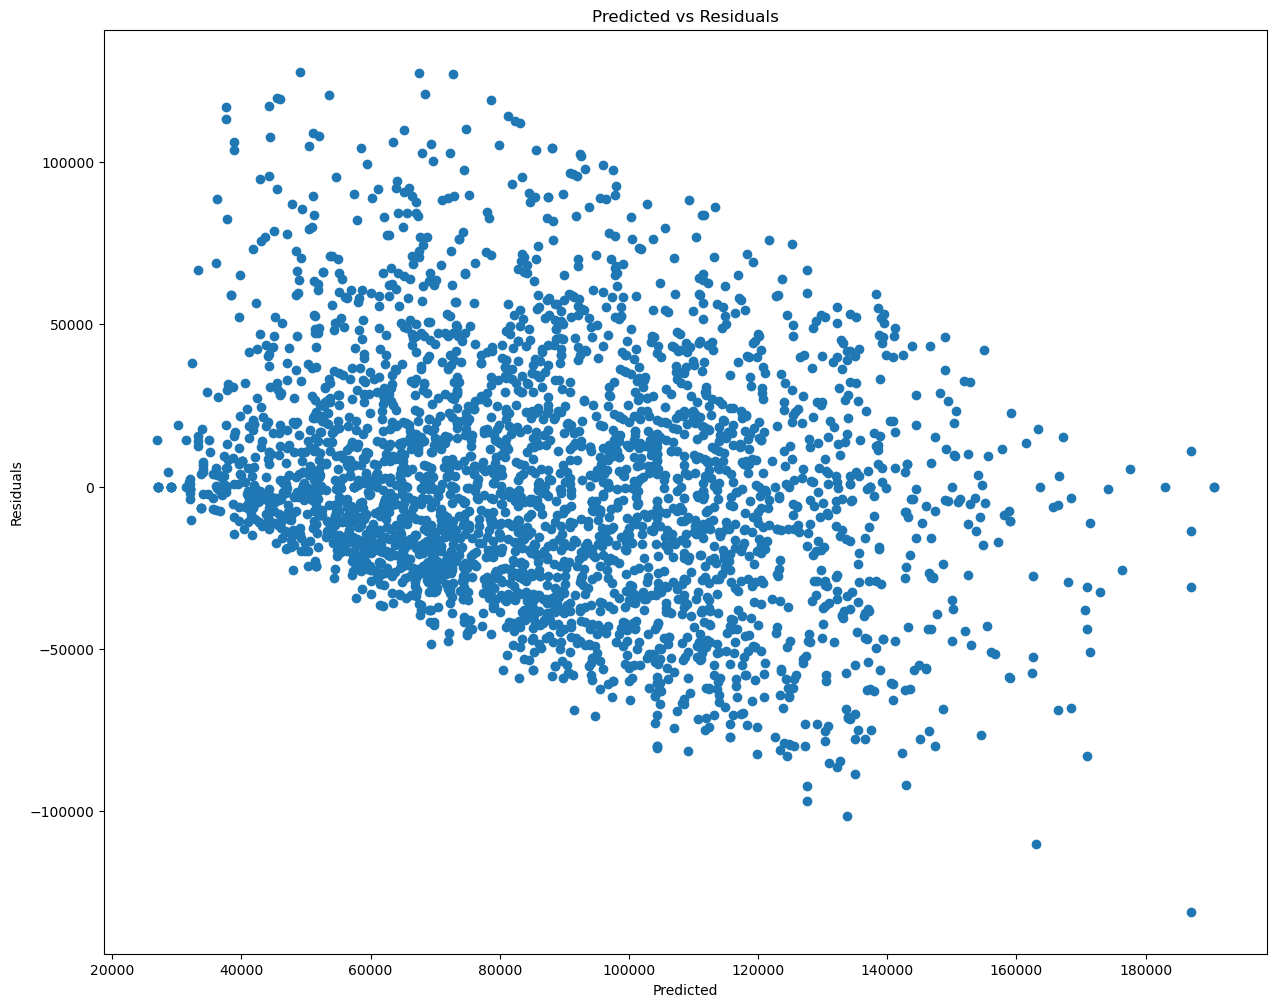

In [43]:
import matplotlib.pyplot as plt


plt.figure(figsize=(15, 12))
plt.scatter(y_test, y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()

plt.figure(figsize=(15, 12))
plt.scatter(y_pred, y_test - y_pred)
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Predicted vs Residuals')
plt.show()

The provided Python code is performing a regression task using a K-Nearest Neighbors (KNN) model to predict median salaries based on several job features. The code includes data preprocessing (such as feature scaling and splitting the data into training and testing sets), model training, prediction, and evaluation using Mean Squared Error (MSE) and cross-validation.

## Comments on the results

The Mean Squared Error (MSE) of 2193137615.069355 and the Root Mean Squared Error (RMSE) scores ranging from around 46135 to 47745 suggest that the model's predictions are not very accurate. The high error rates indicate that the KNN model may need further tuning or a different modeling approach might be more effective.


# Decision Tree Regression

In [47]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [None, 2, 5, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 6, 8, 10],
}

regressor = DecisionTreeRegressor(random_state=0)

grid_search = GridSearchCV(estimator=regressor, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

grid_search.fit(X, y)

print('Best parameters: ', grid_search.best_params_)

best_regressor = grid_search.best_estimator_

y_pred = best_regressor.predict(X_test_scaled)
print('Mean squared error: ', mean_squared_error(y_test, y_pred))

scores = cross_val_score(best_regressor, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')

rmse_scores = np.sqrt(-scores)

print('RMSE scores: ', rmse_scores)
print('Mean RMSE: ', rmse_scores.mean())

Best parameters:  {'max_depth': 5, 'min_samples_leaf': 8, 'min_samples_split': 2}
Mean squared error:  2835608312.7146173
RMSE scores:  [36061.48327162 35314.045744   34927.40575406 35711.50818126
 35456.37148539]
Mean RMSE:  35494.16288726465


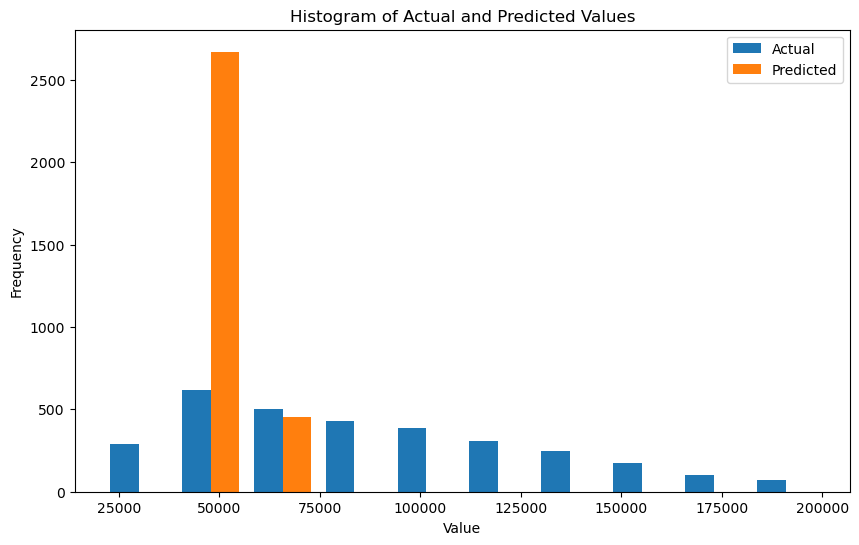

In [45]:
plt.figure(figsize=(10, 6))
plt.hist([y_test, y_pred], label=['Actual', 'Predicted'])
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Actual and Predicted Values')
plt.legend()
plt.show()

## Comments on the results
The error rates are relatively high, suggesting there might be further room for improvement, possibly through additional feature engineering, trying different models.